In [70]:
# --- Preprocessing ---
import pandas as pd
from sklearn.utils import resample
import numpy as np
from afinn import Afinn
import pickle

# --- Processing ---
import re
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import string
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import collections

# --- Postprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
# import utils
# from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dropout, concatenate
from tensorflow.keras import regularizers


from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

class Verarbeitung():
    
    def __init__(self,data_here):
        """
            The data is given as a pandas file.
        """
        self.data_here = data_here
        self.my_info_dict = {}
        
        """
            Depending which dataset is used, this
            will load the bert-encoded dataset in 
            order to use it in the bert model. 
        """
        # 
        #with open('bert_emb2_0traintweets.pk', mode='rb') as f:
        with open('Datasets/bert_emb_airline_sentiment.pk', mode='rb') as f:
            self.bert_here = pickle.load(f)

    def auskunft(self):
        """
            --------------
            --- STATUS ---
            --------------
            This function prints relevant information
            related to the data frame which is being
            updated after each preprocessing step. It
            has a dictionary to where the information 
            is added. 
        """
        self.data_length = len(self.data_here)
        self.my_info_dict['Dataset_Length'] = self.data_length
        self.data_column_names = [name for name in (self.data_here).columns]
        self.my_info_dict['Columns'] = self.data_column_names
        return self.my_info_dict
    
    def labels_to_numbers(self,text_field):
        """
            ---------------------
            --- PREPROCESSING ---
            ---------------------

        """
        if text_field in ['sentiment','label','airline_sentiment']:
            label_encoder = LabelEncoder()
            (self.data_here)['target'] = label_encoder.fit_transform((self.data_here)[text_field])
            self.classes = [k for k in label_encoder.classes_]
            self.my_info_dict['Classes'] = self.classes
            self.my_info_dict['Number_of_Classes'] = len(self.classes)
            self.transformed_classes = label_encoder.fit_transform(self.classes)
            self.my_info_dict['Transformed_Classes'] = list(self.transformed_classes)
            #self.classes_and_transformed_classes = dict(zip(self.classes,self.transformed_classes))
        
    def clean_the_tweets(self,text_field):
        """
            ----------------------
            ---- PREPROCESSING ---
            ----------------------
            It cleans the tweets, removing mentions, 
            url's, leaving only characters, deleting
            extra spaces, making every character 
            lower case and adds a column with the 
            name clean_tweet.
        """
        if text_field in ['text','tweet','sentiment','content']:
            (self.data_here)[text_field] = (self.data_here[text_field]).str.lower()
            mystring = r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
            self.data_here['clean_tweet'] = (self.data_here)[text_field].apply(lambda element: re.sub(mystring,"",element))
            self.data_column_names = [name for name in (self.data_here).columns]
            
    def tokens_and_more(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
            It creates tokens, then chooses the frquency of 
            the top fifty of them and displays them in a graph. 
        """
        if text_field in ['sentiment','label','airline_sentiment']:
            cvec = CountVectorizer()
            cvec.fit(self.data_here['clean_tweet'])
            doc_matrices = [cvec.transform(self.data_here[self.data_here[text_field] == k].clean_tweet) for k in self.my_info_dict['Classes']]
            doc_matrices_sums = [np.sum(my_sum,axis=0) for my_sum in doc_matrices]
            all_squeezed = [np.squeeze(np.asarray(k)) for k in doc_matrices_sums]
            term_freq_df = pd.DataFrame(all_squeezed,columns=cvec.get_feature_names()).transpose()
            term_freq_df.columns = self.my_info_dict['Classes']
            term_freq_df['total'] = sum([term_freq_df[k] for k in self.my_info_dict['Classes']])#term_freq_df['positive'] + term_freq_df['neutral'] + term_freq_df['negative']
            term_freq_df.sort_values(by='total', ascending=False)
            print(term_freq_df.sort_values(by='total', ascending=False).head())
            y_neg = np.arange(50)
            for kindex, class_is_here in enumerate(self.my_info_dict['Classes']):
                fig, ax = plt.subplots(figsize=(13,7))
                ax.set_axis_off()
                ax = fig.add_subplot(1,1,1)
                ax.bar(y_neg, term_freq_df.sort_values(by=class_is_here,ascending=False)[class_is_here][:50], align='center',alpha=0.5)
                ax.set_xticks(y_neg)
                ax.set_xticklabels(term_freq_df.sort_values(by=class_is_here,ascending=False)[class_is_here][:50].index,rotation='vertical')
                ax.set_ylabel('Frequency')
                ax.set_xlabel('Top 50 %s tokens'%(self.my_info_dict['Classes'][kindex]))
                ax.set_title('Top 50 tokens in %s tweets'%(self.my_info_dict['Classes'][kindex]))
            plt.show()

    def normalizer(self,text_field):
        """
            ---------------------
            --- PREPROCESSING ---
            ---------------------
            This function removes the stopwords
            and adds the tokens per tweet in a 
            new column. This is part of the 
            preprocessing because this column
            plays an important role as the
            input in the models. 
        """
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        
        def tokenize(s): 
            return re_tok.sub(r' \1 ', s).split()
        
        self.data_here['tokenized'] = self.data_here[text_field].apply(lambda row: tokenize(row))
        stop = set(stopwords.words('english'))
        stop.update(['amp', 'rt', 'cc'])
        stop = stop - set(['no', 'not'])
        
        def remove_stopwords(row):
            return [t for t in row if t not in stop]
        
        self.data_here['tokenized'] = self.data_here['tokenized'].apply(lambda row: remove_stopwords(row))
        
        def update_vocab_counter(row):
            for word in row:
                vocab_counter[word] += 1
                
        vocab_counter = collections.Counter()
        self.data_here['tokenized'].apply(update_vocab_counter)
        vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)
        
        self.my_info_dict['Vocabulary'] = len(vocab)
        max_words = 5000
        self.my_info_dict['Vocabulary_Size_to_Use'] = max_words
        w2id = {w:i+1 for i, w in enumerate(vocab[:max_words-1])}
        w2id['unk'] = 0
        
        self.my_info_dict['Embedding_Dimension_to_Use'] = 50
        
        def transform_to_ids(row):
            return [w2id[w] if w in w2id else w2id['unk'] for w in row]
        
        self.data_here['tokenized_int'] = self.data_here['tokenized'].apply(lambda x: transform_to_ids(x))
        lens = self.data_here['tokenized_int'].apply(lambda x: len(x))
        maxlen = int(np.floor(max(lens)))
        self.my_info_dict['Words_Per_Document'] = maxlen
        
    def prozent_wrt(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
            This function computes the number of sentiments
            in the target column and returns a plot.
        """
        if text_field in ['sentiment','label','airline_sentiment']:
            percentage = (self.data_here).groupby([text_field]).count()
            percentage['clean_tweet'].plot(kind='bar', 
                                           figsize=(8, 6), 
                                           legend=False, 
                                           title='Number of tweets by class')
            plt.show()
       
    def afinn_stuff(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
        """
        af = Afinn()

        # compute sentiment scores (polarity) and labels
        sentiment_scores = [af.score(article) for article in self.data_here['clean_tweet']]
        sentiment_category = ['positive' if score > 0 
                                  else 'negative' if score < 0 
                                      else 'neutral' 
                                          for score in sentiment_scores]

        # sentiment statistics per news category
        if text_field in ['sentiment','label','airline_sentiment']:
            df = pd.DataFrame([list(self.data_here[text_field]), sentiment_scores, sentiment_category]).T
            df.columns = ['sentiment', 'sentiment_score', 'sentiment_category']
            df['sentiment_score'] = df.sentiment_score.astype('float')
            df.groupby(by=['sentiment']).describe()

            f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
            sp = sns.stripplot(x='sentiment', y="sentiment_score",hue='sentiment', data=df, ax=ax1)
            bp = sns.boxplot(x='sentiment', y="sentiment_score", hue='sentiment', data=df, palette="Set2", ax=ax2)
            t = f.suptitle('Visualizing Sentiment', fontsize=14)
            plt.show()
          
    def patterns_of(self,sentiment_field,sentiment):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
        """
        def ngrams(input_list):
            #onegrams = input_list
            bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
            trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
            return bigrams+trigrams
        self.data_here['grams'] = self.data_here['tokenized'].apply(ngrams)

        def count_words(input):
            cnt = collections.Counter()
            for row in input:
                for word in row:
                    cnt[word] += 1
            return cnt
        
        self.data_here[(self.data_here[sentiment_field] == sentiment)][['grams']].apply(count_words)['grams'].most_common(20)
        return self.data_here[(self.data_here[sentiment_field] == sentiment)][['grams']].apply(count_words)['grams'].most_common(20)
    
    def first_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
            The first model resembles a linear model,
            where just a softmax function is used at 
            the end of the process once we have set
            the variables for the embedding. 
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.data_here['tokenized_int'].values, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        x_train = pad_sequences(X_train, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        x_test = pad_sequences(X_test, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def baseline_model():
            model = Sequential([Embedding(input_dim=self.my_info_dict['Vocabulary_Size_to_Use'], 
                                          output_dim=self.my_info_dict['Embedding_Dimension_to_Use'], 
                                          input_length=self.my_info_dict['Words_Per_Document']),
                                Flatten(),
                                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax')])
            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
            return model
        
        estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, x_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/linear.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = baseline_model()
        model.fit(x_train, dummy_y, validation_data=(x_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(x_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))
        
    def bert_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.bert_here, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def baseline_model():
            model = Sequential([
                Dense(100, activation='relu'),
                Dropout(0.5),
                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax'),
            ])
            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
            return model
        
        estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, X_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/bert.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = baseline_model()
        model.fit(X_train, dummy_y, validation_data=(X_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(X_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))
        
    def lstm_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.data_here['tokenized_int'].values, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        x_train = pad_sequences(X_train, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        x_test = pad_sequences(X_test, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def simple_lstm():
            model = Sequential([Embedding(input_dim=self.my_info_dict['Vocabulary_Size_to_Use'], 
                                      output_dim=self.my_info_dict['Embedding_Dimension_to_Use'], 
                                      input_length=self.my_info_dict['Words_Per_Document']),
                            LSTM(25),
                            Dense(self.my_info_dict['Number_of_Classes'], activation='softmax')])

            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

            return model
        
        estimator = KerasClassifier(build_fn=simple_lstm, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, x_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/lstm.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = simple_lstm()
        model.fit(x_train, dummy_y, validation_data=(x_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        
        # serialize model to JSON
        model_json = model.to_json()
        with open("lstm_model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("lstm_model_weights.h5")
        
        preds = model.predict(x_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))


In [36]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [37]:
header = ["value", "text"]
train = pd.read_csv("parsed_data/sst_train_sentences.csv", 
                    names=header)
test = pd.read_csv("parsed_data/sst_test.csv", 
                   names=header)
dev = pd.read_csv("parsed_data/sst_dev.csv", 
                  names=header)


classes = [((0, 0.2),0), ((0.2, 0.4),1), 
           ((0.4, 0.6),2), ((0.6, 0.8),3), ((0.8, 1.0),4)]

def get_label(x):
    for key, value in classes:            
        if key[0] <= x <= key[1]:
            return value

# [0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]
train["label"] = train["value"].apply(get_label)
test["label"] = test["value"].apply(get_label)
dev["label"] = dev["value"].apply(get_label)

y_train = train["label"]
y_test = test["label"]
y_dev = dev["label"]


# vectorizer = TfidfVectorizer(min_df=0, lowercase=False)
# vectorizer.fit(train["text"])

# train_vects = vectorizer.transform(train["text"]).toarray()
# test_vects =  vectorizer.transform(test["text"]).toarray()
# dev_vects =  vectorizer.transform(dev["text"]).toarray()


# convert list of tokens/words to indexes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train["text"])
sequences_train = tokenizer.texts_to_sequences(train["text"])
max_input_lenght = max([len(x) for x in sequences_train])
word_index = tokenizer.word_index

# # pad all the sequences of indexes to the 'max_input_lenght'
# x_train_data_padded = pad_sequences(
#     sequences_train, 
#     maxlen=max_input_lenght, 
#     padding='post', 
#     truncating='post')

# x_dev_data_padded = pad_sequences(
#     tokenizer.texts_to_sequences(dev["text"]), 
#     maxlen=max_input_lenght, 
#     padding='post', 
#     truncating='post')

# x_test_data_padded = pad_sequences(
#     tokenizer.texts_to_sequences(test["text"]), 
#     maxlen=max_input_lenght, 
#     padding='post', 
#     truncating='post')

# Encode the labels, each must be a vector with 
# dim = num. of possible labels
le = LabelEncoder()
le.fit(y_train)

labels_encoded_train = le.transform(y_train)
labels_encoded_dev = le.transform(y_dev)
labels_encoded_test = le.transform(y_test)

categorical_labels_train = to_categorical(labels_encoded_train, 
                                          num_classes=None)
categorical_labels_dev = to_categorical(labels_encoded_dev, 
                                        num_classes=None)
categorical_labels_test = to_categorical(labels_encoded_test, 
                                         num_classes=None)


In [38]:
train.shape

(8534, 3)

In [39]:
dev.shape

(1100, 3)

In [40]:
test.shape

(2210, 3)

In [41]:
vab = Verarbeitung(train)
vab.auskunft()

{'Dataset_Length': 8534, 'Columns': ['value', 'text', 'label']}

In [42]:
train.head(1)

,value,text,label
0,0.69444,Reno himself can take credit for most of the movie 's success .,3


In [43]:
vab.labels_to_numbers('label')
vab.auskunft()

{'Dataset_Length': 8534,
 'Columns': ['value', 'text', 'label', 'target'],
 'Classes': [0, 1, 2, 3, 4],
 'Number_of_Classes': 5,
 'Transformed_Classes': [0, 1, 2, 3, 4]}

In [44]:
vab.clean_the_tweets('text')
vab.auskunft()

{'Dataset_Length': 8534,
 'Columns': ['value', 'text', 'label', 'target', 'clean_tweet'],
 'Classes': [0, 1, 2, 3, 4],
 'Number_of_Classes': 5,
 'Transformed_Classes': [0, 1, 2, 3, 4]}

       0     1     2     3     4  total
the  941  1863  1349  2100  1048  7301 
and  549  989   642   1382  911   4473 
of   557  1042  765   1293  736   4393 
to   421  845   583   783   389   3021 
is   355  678   465   677   384   2559 


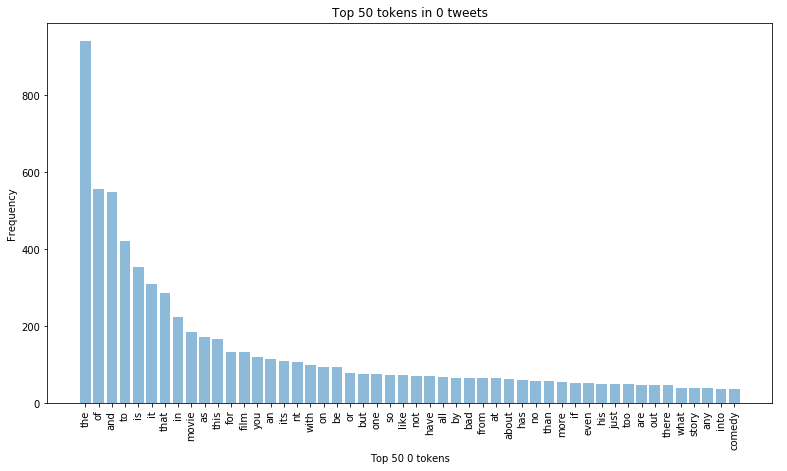

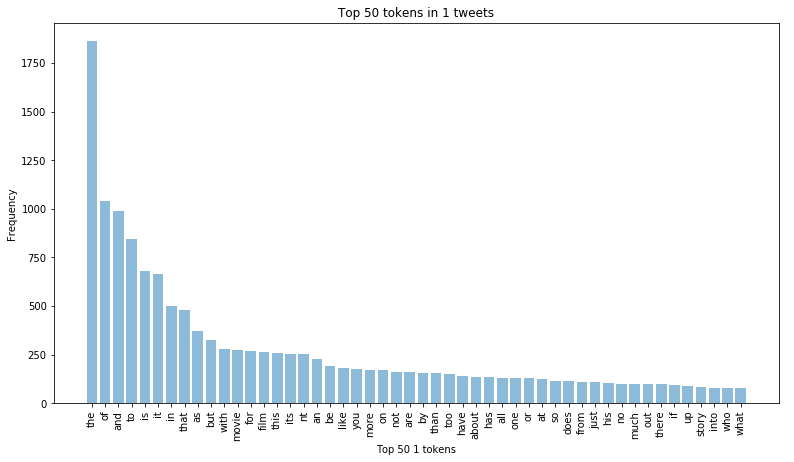

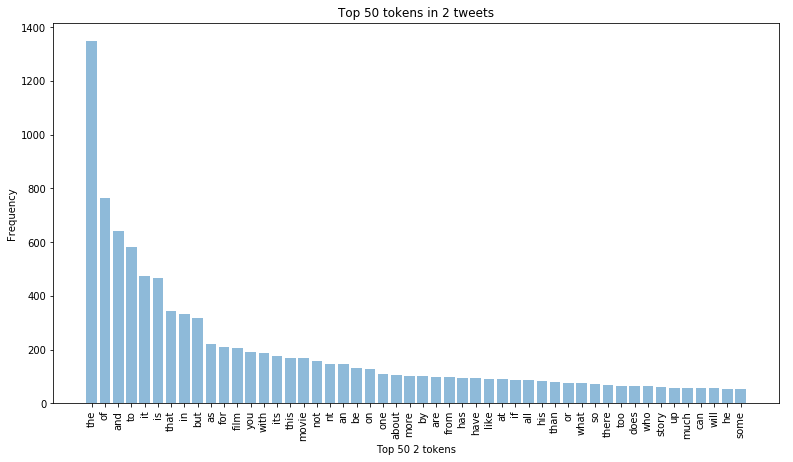

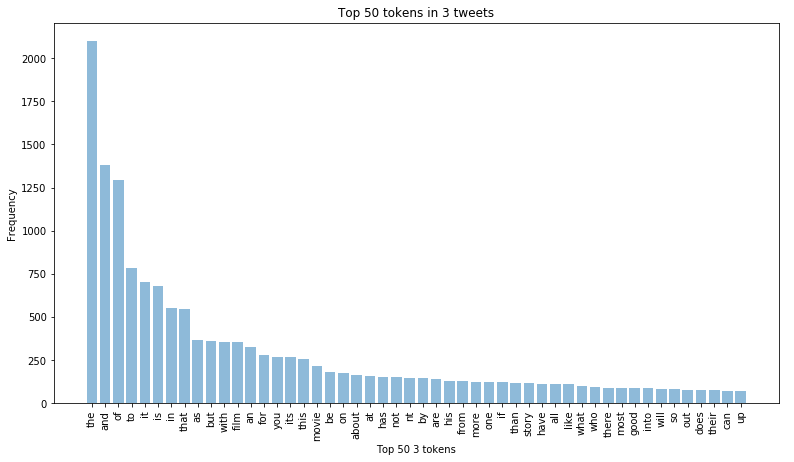

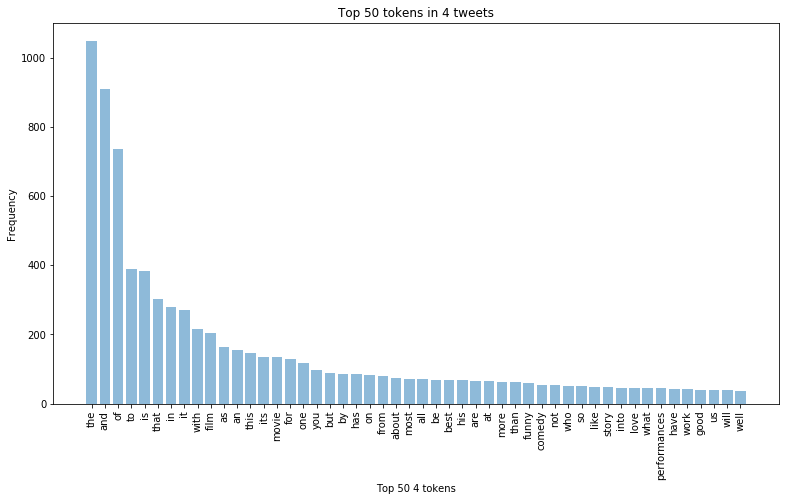

In [45]:
vab.tokens_and_more('label')

In [46]:
vab.data_here.head()

,value,text,label,target,clean_tweet
0,0.69444,reno himself can take credit for most of the movie 's success .,3,3,reno himself can take credit for most of the movie s success
1,0.70833,"despite the film 's shortcomings , the stories are quietly moving .",3,3,despite the film s shortcomings the stories are quietly moving
2,0.26389,"despite its dry wit and compassion , the film suffers from a philosophical emptiness and maddeningly sedate pacing .",1,1,despite its dry wit and compassion the film suffers from a philosophical emptiness and maddeningly sedate pacing
3,0.47222,the central character is n't complex enough to hold our interest .,2,2,the central character is nt complex enough to hold our interest
4,0.13889,"rifkin no doubt fancies himself something of a hubert selby jr. , but there is n't an ounce of honest poetry in his entire script ; it 's simply crude and unrelentingly exploitative .",0,0,rifkin no doubt fancies himself something of a hubert selby jr but there is nt an ounce of honest poetry in his entire script it s simply crude and unrelentingly exploitative


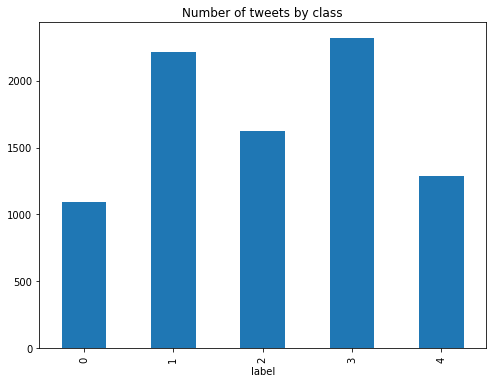

In [47]:
vab.prozent_wrt('label')

In [48]:
vab.auskunft()

{'Dataset_Length': 8534,
 'Columns': ['value', 'text', 'label', 'target', 'clean_tweet'],
 'Classes': [0, 1, 2, 3, 4],
 'Number_of_Classes': 5,
 'Transformed_Classes': [0, 1, 2, 3, 4]}

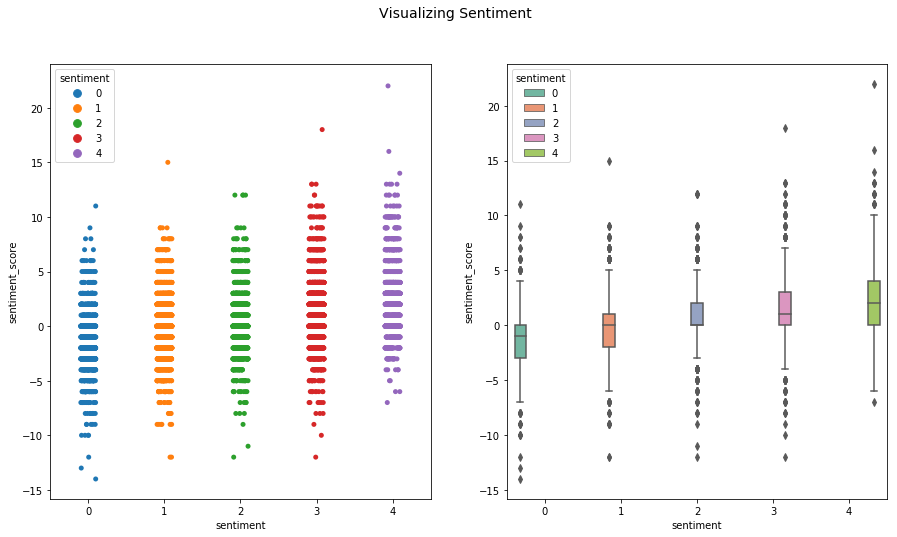

In [49]:
vab.afinn_stuff('label')

In [50]:
vab.normalizer('clean_tweet')
vab.auskunft()

{'Dataset_Length': 8534,
 'Columns': ['value',
  'text',
  'label',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': [0, 1, 2, 3, 4],
 'Number_of_Classes': 5,
 'Transformed_Classes': [0, 1, 2, 3, 4],
 'Vocabulary': 16296,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 29}

In [51]:
vab.data_here.head()

,value,text,label,target,clean_tweet,tokenized,tokenized_int
0,0.69444,reno himself can take credit for most of the movie 's success .,3,3,reno himself can take credit for most of the movie s success,"[reno, take, credit, movie, success]","[1043, 101, 974, 2, 588]"
1,0.70833,"despite the film 's shortcomings , the stories are quietly moving .",3,3,despite the film s shortcomings the stories are quietly moving,"[despite, film, shortcomings, stories, quietly, moving]","[124, 1, 4123, 331, 835, 161]"
2,0.26389,"despite its dry wit and compassion , the film suffers from a philosophical emptiness and maddeningly sedate pacing .",1,1,despite its dry wit and compassion the film suffers from a philosophical emptiness and maddeningly sedate pacing,"[despite, dry, wit, compassion, film, suffers, philosophical, emptiness, maddeningly, sedate, pacing]","[124, 669, 279, 1550, 1, 490, 1044, 3288, 0, 0, 636]"
3,0.47222,the central character is n't complex enough to hold our interest .,2,2,the central character is nt complex enough to hold our interest,"[central, character, nt, complex, enough, hold, interest]","[899, 59, 3, 373, 22, 713, 287]"
4,0.13889,"rifkin no doubt fancies himself something of a hubert selby jr. , but there is n't an ounce of honest poetry in his entire script ; it 's simply crude and unrelentingly exploitative .",0,0,rifkin no doubt fancies himself something of a hubert selby jr but there is nt an ounce of honest poetry in his entire script it s simply crude and unrelentingly exploitative,"[rifkin, no, doubt, fancies, something, hubert, selby, jr, nt, ounce, honest, poetry, entire, script, simply, crude, unrelentingly, exploitative]","[3289, 8, 670, 0, 35, 0, 0, 4124, 3, 0, 404, 771, 546, 66, 175, 1739, 0, 1740]"


In [52]:
vab.lstm_model()

5  experiments were run:  [0.3671083425695043, 0.38437499897554517, 0.368256449885812, 0.3870211090773134, 0.37685691869939275]
Train on 6400 samples, validate on 2134 samples
Epoch 1/5
6400/6400 [==============================] - 2s 310us/step - loss: 1.5800 - acc: 0.2755 - val_loss: 1.5713 - val_acc: 0.2690

Epoch 00001: val_acc improved from -inf to 0.26898, saving model to /home/user/Documents/aml/project_sentiment/results/lstm.hdf5
Epoch 2/5
6400/6400 [==============================] - 1s 147us/step - loss: 1.5226 - acc: 0.3697 - val_loss: 1.5255 - val_acc: 0.3327

Epoch 00002: val_acc improved from 0.26898 to 0.33271, saving model to /home/user/Documents/aml/project_sentiment/results/lstm.hdf5
Epoch 3/5
6400/6400 [==============================] - 1s 141us/step - loss: 1.3154 - acc: 0.4455 - val_loss: 1.4473 - val_acc: 0.3693

Epoch 00003: val_acc improved from 0.33271 to 0.36926, saving model to /home/user/Documents/aml/project_sentiment/results/lstm.hdf5
Epoch 4/5
6400/6400 [==

In [53]:
from keras.models import model_from_json
# load json and create model
json_file = open('lstm_model.json', 'r')
lstm_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(lstm_model_json)
# load weights into new model
# lstm_model.load_weights("lstm_model_weights.h5")

In [54]:
vab.data_here.head(1)

,value,text,label,target,clean_tweet,tokenized,tokenized_int
0,0.69444,reno himself can take credit for most of the movie 's success .,3,3,reno himself can take credit for most of the movie s success,"[reno, take, credit, movie, success]","[1043, 101, 974, 2, 588]"


In [55]:
vab_dev = Verarbeitung(dev)
vab_dev.clean_the_tweets('text')
vab_dev.normalizer('clean_tweet')

vab_test = Verarbeitung(test)
vab_test.clean_the_tweets('text')
vab_test.normalizer('clean_tweet')


In [56]:
x_train = pad_sequences(vab.data_here['tokenized_int'], 
                        maxlen=vab.my_info_dict['Words_Per_Document'], 
                        value=0, padding='pre')

x_dev = pad_sequences(vab_dev.data_here['tokenized_int'], 
                        maxlen=vab.my_info_dict['Words_Per_Document'], 
                        value=0, padding='pre')

x_test = pad_sequences(vab_test.data_here['tokenized_int'], 
                        maxlen=vab.my_info_dict['Words_Per_Document'], 
                        value=0, padding='pre')


# LSTM

In [57]:
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


history = lstm_model.fit(x_train, categorical_labels_train, 
               validation_data=(x_dev, categorical_labels_dev), 
               epochs=5, 
               batch_size=100)


Train on 8534 samples, validate on 1100 samples
Epoch 1/5
8534/8534 [==============================] - 2s 268us/step - loss: 1.5744 - acc: 0.2799 - val_loss: 1.5712 - val_acc: 0.2709
Epoch 2/5
8534/8534 [==============================] - 1s 141us/step - loss: 1.4313 - acc: 0.3936 - val_loss: 1.6945 - val_acc: 0.2673
Epoch 3/5
8534/8534 [==============================] - 1s 138us/step - loss: 1.2056 - acc: 0.4722 - val_loss: 1.9015 - val_acc: 0.2545
Epoch 4/5
8534/8534 [==============================] - 1s 135us/step - loss: 1.0681 - acc: 0.5410 - val_loss: 2.0633 - val_acc: 0.2355
Epoch 5/5
8534/8534 [==============================] - 1s 134us/step - loss: 0.9308 - acc: 0.6138 - val_loss: 2.5363 - val_acc: 0.2336


Training Accuracy: 0.7226
Testing Accuracy:  0.2493


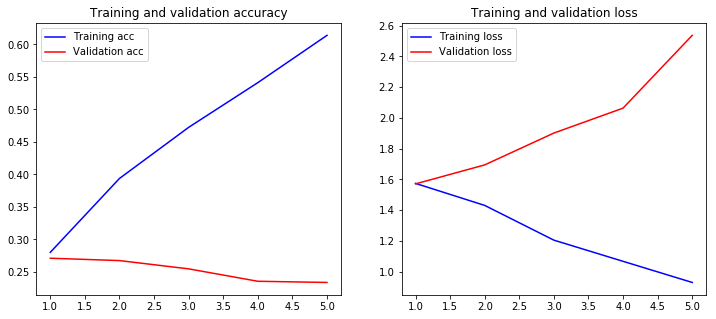

In [58]:
loss, accuracy = lstm_model.evaluate(x_train, categorical_labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_model.evaluate(x_test, categorical_labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [60]:
preds = lstm_model.predict(x_test)
print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.05      0.01      0.01       279
           1       0.30      0.35      0.33       633
           2       0.22      0.26      0.24       389
           3       0.25      0.38      0.31       510
           4       0.14      0.07      0.09       399

   micro avg       0.25      0.25      0.25      2210
   macro avg       0.19      0.22      0.20      2210
weighted avg       0.22      0.25      0.22      2210



In [146]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 29, 50)            250000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 130       
Total params: 257,730
Trainable params: 257,730
Non-trainable params: 0
_________________________________________________________________


# CNN

## random_emb

In [49]:

def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer


def get_conv_pool(x_input, suffix, n_grams=[3,4,5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu, name='Conv_'+suffix+'_'+str(n))(x_input)
        branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_'+suffix+'_'+str(n))(branch)
        branch = Flatten(name='Flatten_'+suffix+'_'+str(n))(branch)
        branches.append(branch)
    return branches

def get_cnn_rand(embedding_dim, vocab_size, max_len, num_classes):
    # create the embedding layer
    embedding_matrix = np.random.rand(vocab_size, embedding_dim)
    embedding_layer = get_embeddings_layer(embedding_matrix, 'embedding_layer_dynamic', max_len, trainable=True)

    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, 'dynamic')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.5)(z)

    # pass the concatenated vector to the predition layer
    o = Dense(5, activation='softmax', name='output',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'categorical_crossentropy'}, optimizer='sgd', metrics=['accuracy'])

    return model

Train on 8534 samples, validate on 1100 samples
Epoch 1/20
8534/8534 [==============================] - 8s 956us/sample - loss: 1.7351 - acc: 0.2581 - val_loss: 1.6856 - val_acc: 0.2482
Epoch 2/20
8534/8534 [==============================] - 8s 905us/sample - loss: 1.6682 - acc: 0.2738 - val_loss: 1.6736 - val_acc: 0.2591
Epoch 3/20
8534/8534 [==============================] - 8s 972us/sample - loss: 1.6549 - acc: 0.2792 - val_loss: 1.6713 - val_acc: 0.2545
Epoch 4/20
8534/8534 [==============================] - 8s 936us/sample - loss: 1.6437 - acc: 0.2891 - val_loss: 1.6620 - val_acc: 0.2700
Epoch 5/20
8534/8534 [==============================] - 9s 1ms/sample - loss: 1.6330 - acc: 0.2933 - val_loss: 1.6588 - val_acc: 0.2609
Epoch 6/20
8534/8534 [==============================] - 8s 963us/sample - loss: 1.6271 - acc: 0.2920 - val_loss: 1.6590 - val_acc: 0.2464
Epoch 7/20
8534/8534 [==============================] - 8s 987us/sample - loss: 1.6162 - acc: 0.3082 - val_loss: 1.6518 - val_

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.30      0.53      0.39       633
           2       0.26      0.10      0.14       389
           3       0.25      0.47      0.33       510
           4       0.00      0.00      0.00       399

   micro avg       0.28      0.28      0.28      2210
   macro avg       0.16      0.22      0.17      2210
weighted avg       0.19      0.28      0.21      2210



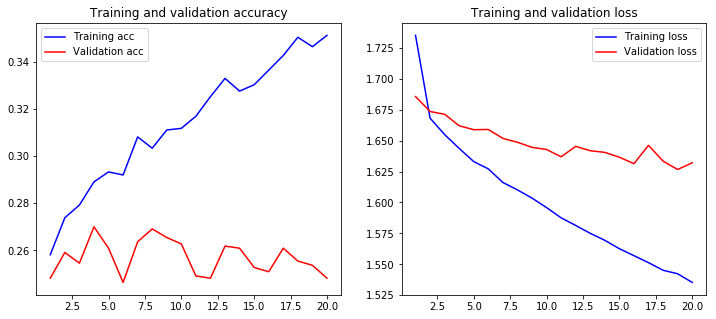

In [81]:
cnn_model = get_cnn_rand(300, len(word_index)+1, vab.my_info_dict['Words_Per_Document'], 5)
history = cnn_model.fit(x=x_train, y=categorical_labels_train, 
                      batch_size=50, epochs=20,
                    validation_data=(x_dev, categorical_labels_dev))

loss, accuracy = cnn_model.evaluate(x_train, categorical_labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = cnn_model.evaluate(x_test, categorical_labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


preds = cnn_model.predict(x_test)
print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))

## word2vec embedding

In [116]:
def get_cnn_pre_trained_embeddings(embedding_layer, max_len, num_classes):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, 'static')
    z = concatenate(branches, axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(num_classes, activation='softmax', name='output',
#              kernel_regularizer=regularizers.l2(0.15),
#                 activity_regularizer=regularizers.l2(0.15)
             )(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'categorical_crossentropy'}, optimizer='sgd', metrics=['accuracy'])

    return model

import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_model = gensim.models.KeyedVectors\
        .load_word2vec_format('word2vec/GoogleNews-vectors-negative300-SLIM.bin', binary=True)  
NUM_WORDS = 20000
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# del(word2vec_model)

from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], #np.random.rand(vocabulary_size, EMBEDDING_DIM)
                            trainable=False)



Train on 8534 samples, validate on 1100 samples
Epoch 1/20
8534/8534 [==============================] - 11s 1ms/sample - loss: 1.5795 - acc: 0.2687 - val_loss: 1.5724 - val_acc: 0.2845
Epoch 2/20
8534/8534 [==============================] - 10s 1ms/sample - loss: 1.5652 - acc: 0.2844 - val_loss: 1.5718 - val_acc: 0.2782
Epoch 3/20
8534/8534 [==============================] - 10s 1ms/sample - loss: 1.5587 - acc: 0.2901 - val_loss: 1.5716 - val_acc: 0.2809
Epoch 4/20
8534/8534 [==============================] - 10s 1ms/sample - loss: 1.5541 - acc: 0.2906 - val_loss: 1.5694 - val_acc: 0.2891
Epoch 5/20
8534/8534 [==============================] - 10s 1ms/sample - loss: 1.5500 - acc: 0.2966 - val_loss: 1.5699 - val_acc: 0.2727
Epoch 6/20
8534/8534 [==============================] - 10s 1ms/sample - loss: 1.5465 - acc: 0.2996 - val_loss: 1.5705 - val_acc: 0.2682
Epoch 7/20
8534/8534 [==============================] - 10s 1ms/sample - loss: 1.5431 - acc: 0.3028 - val_loss: 1.5698 - val_acc: 

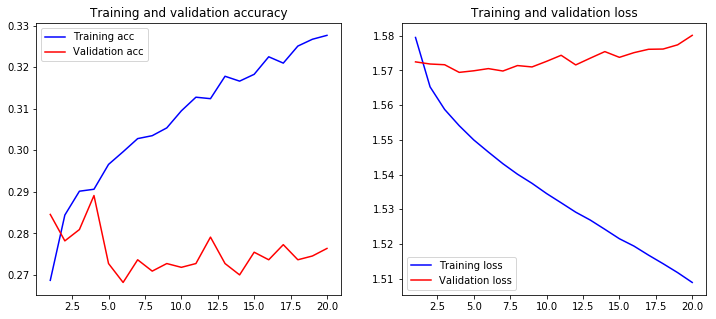

In [118]:
cnn_w2v_model = get_cnn_pre_trained_embeddings(embedding_layer, 
                                               vab.my_info_dict['Words_Per_Document']+10, 5)
history = cnn_w2v_model.fit(x=x_train, y=categorical_labels_train, 
                      batch_size=50, epochs=20,
                    validation_data=(x_dev, categorical_labels_dev))

loss, accuracy = cnn_w2v_model.evaluate(x_train, categorical_labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = cnn_w2v_model.evaluate(x_test, categorical_labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

preds = cnn_w2v_model.predict(x_test)
print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))

# Linear Model

In [140]:
from sklearn.linear_model import SGDClassifier
tfidf_transf = TfidfVectorizer()
tfidf_transf.fit(vab.data_here['clean_tweet'])
tfidf_train = tfidf_transf.transform(vab.data_here['clean_tweet'])
tfidf_test = tfidf_transf.transform(vab_test.data_here['clean_tweet'])
# tfidf_dev= tfidf_transf.transform(vab_dev.data_here['clean_tweet'])

In [141]:
sg =  SGDClassifier(max_iter=100, random_state=42)
sg.fit(tfidf_train, y_train)
y_pred = sg.predict(tfidf_test)
print(metrics.classification_report(y_test, y_pred))

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.38      0.28      0.32       279
           1       0.46      0.51      0.48       633
           2       0.21      0.13      0.16       389
           3       0.37      0.51      0.43       510
           4       0.49      0.45      0.47       399

   micro avg       0.40      0.40      0.40      2210
   macro avg       0.38      0.38      0.37      2210
weighted avg       0.39      0.40      0.39      2210



# BERT

In [ ]:
from bert_serving.client import BertClient
bc = BertClient()

cleaned_train_bert_embeded = bc.encode(vab.data_here['clean_tweet'].values.tolist())
with open('cleaned_train_bert_embeded.pickle', 'wb') as f:
    pickle.dump(cleaned_train_bert_embeded, f)

cleaned_test_bert_embeded = bc.encode(vab_test.data_here['clean_tweet'].values.tolist())
with open('cleaned_test_bert_embeded.pickle', 'wb') as f:
    pickle.dump(cleaned_test_bert_embeded, f)

cleaned_dev_bert_embeded = bc.encode(vab_dev.data_here['clean_tweet'].values.tolist())
with open('cleaned_dev_bert_embeded.pickle', 'wb') as f:
    pickle.dump(cleaned_dev_bert_embeded, f)

In [80]:

cleaned_train_bert_embeded = pickle.load(open('cleaned_train_bert_embeded.pickle','rb'))
cleaned_test_bert_embeded = pickle.load(open('cleaned_test_bert_embeded.pickle','rb'))
cleaned_dev_bert_embeded = pickle.load(open('cleaned_dev_bert_embeded.pickle','rb'))


## bert neural net

In [81]:
inputs = Input(shape=(cleaned_train_bert_embeded.shape[1],))
first_layer = Dense(400, activation=relu)(inputs)
dr1 = Dropout(0.5)(first_layer)
second_layer = Dense(128, activation=relu)(dr1)
dr2 = Dropout(0.5)(second_layer)
third_layer = Dense(64)(dr2)
dr3 = Dropout(0.5)(third_layer)

# pass the concatenated vector to the predition layer
outputs = Dense(5, activation='softmax', name='output', kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01))(dr3)

model_bert = Model(inputs=inputs, outputs=outputs)
model_bert.compile(loss={'output': 'categorical_crossentropy'}, optimizer='sgd', metrics=['accuracy'])


Train on 8534 samples, validate on 1100 samples
Epoch 1/20
8534/8534 [==============================] - 2s 209us/step - loss: 2.2604 - acc: 0.2435 - val_loss: 2.1248 - val_acc: 0.3609
Epoch 2/20
8534/8534 [==============================] - 1s 65us/step - loss: 2.1511 - acc: 0.2782 - val_loss: 2.0789 - val_acc: 0.3836
Epoch 3/20
8534/8534 [==============================] - 1s 69us/step - loss: 2.0999 - acc: 0.3154 - val_loss: 2.0213 - val_acc: 0.3800
Epoch 4/20
8534/8534 [==============================] - 1s 66us/step - loss: 2.0584 - acc: 0.3340 - val_loss: 1.9682 - val_acc: 0.3955
Epoch 5/20
8534/8534 [==============================] - 1s 65us/step - loss: 2.0189 - acc: 0.3502 - val_loss: 1.9251 - val_acc: 0.4027
Epoch 6/20
8534/8534 [==============================] - 1s 64us/step - loss: 1.9768 - acc: 0.3706 - val_loss: 1.8985 - val_acc: 0.4182
Epoch 7/20
8534/8534 [==============================] - 1s 65us/step - loss: 1.9456 - acc: 0.3833 - val_loss: 1.8699 - val_acc: 0.4236
Epoch 

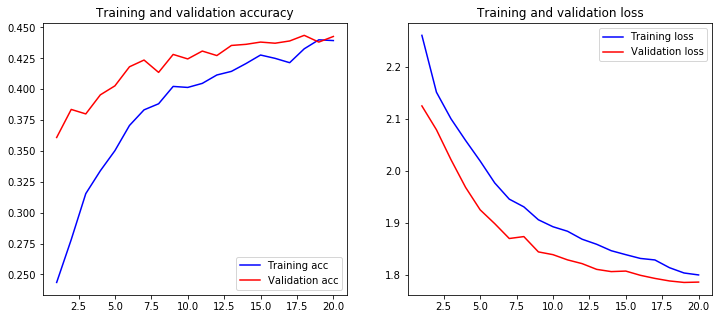

In [82]:

history = model_bert.fit(x=cleaned_train_bert_embeded, y=categorical_labels_train, 
                      batch_size=50, epochs=20,
                    validation_data=(cleaned_dev_bert_embeded, categorical_labels_dev))

loss, accuracy = model_bert.evaluate(cleaned_train_bert_embeded, categorical_labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_bert.evaluate(cleaned_test_bert_embeded, categorical_labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

preds = model_bert.predict(cleaned_test_bert_embeded)
print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))

In [79]:
model_bert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 400)               307600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               51328     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
__________